In [1]:
import pandas as pd
import ast
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

df = pd.read_excel("hasil_tfidf_ngram.xlsx")
y = df["label"]

def clean_tfidf(x):
    s = str(x)
    s = s.replace("np.float64", "")
    s = s.replace("float64", "")
    s = s.replace("float32", "")
    s = re.sub(r"defaultdict\([^)]*\),?\s*", "", s)
    s = re.sub(r"\(\s*([0-9.]+)\s*\)", r"\1", s)
    d = ast.literal_eval(s)
    return {k: float(v) for k, v in d.items()}

tfidf_dicts = df["TFIDF"].apply(clean_tfidf)

def ngram_to_dict(s):
    items = str(s).split(",")
    items = [i.strip() for i in items if i.strip() != ""]
    return {f"ngram_{i}": 1 for i in items}

ngram_dicts = df["NGRAM"].apply(ngram_to_dict)

combined_features = [
    {**tfidf_dicts.iloc[i], **ngram_dicts.iloc[i]}
    for i in range(len(df))
]

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(combined_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

param_grid = {
    "alpha": [0.1, 0.3, 0.5, 1.0, 2.0],
    "fit_prior": [True, False]
}

model = MultinomialNB()

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== BEST PARAMETERS ===")
print(grid_search.best_params_)

print("\n=== EVALUATION REPORT ===")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== BEST PARAMETERS ===
{'alpha': 2.0, 'fit_prior': True}

=== EVALUATION REPORT ===
              precision    recall  f1-score   support

          CG       0.85      0.92      0.88      4044
          OR       0.91      0.83      0.87      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



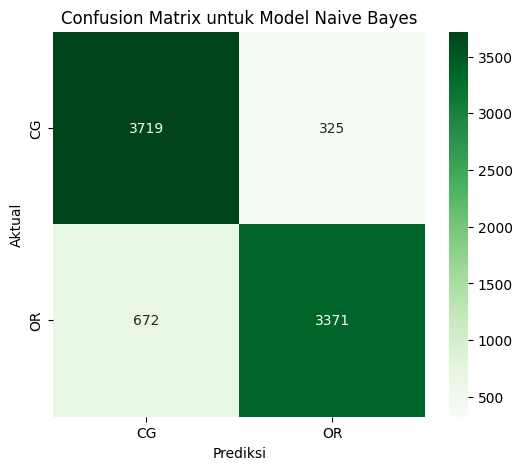

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model Naive Bayes")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()
